In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import numpy as np
import pandas as pd

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D , Conv2D,Flatten
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import Activation,BatchNormalization

In [3]:
os.listdir(r"C:\Users\anmol\impli\xray_dataset_covid19\train")

['NORMAL', 'PNEUMONIA']

In [10]:
# Get the current working directory
cwd = os.getcwd()

# Print the current working directory
print("Current working directory: {0}".format(cwd))

Current working directory: C:\Users\anmol\impli


In [26]:
train_dir= r"C:\Users\anmol\impli\xray_dataset_covid19\train"
test_dir= r"C:\Users\anmol\impli\xray_dataset_covid19\test"

num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))

In [27]:
weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.50
Weight for class 1: 0.50


In [12]:
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [14]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180, 180))


test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [15]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.applications import VGG16


vgg16_base_model = VGG16(input_shape=(180,180,3),include_top=False,weights='imagenet')


In [16]:
vgg16_base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [17]:
vgg16_model = Sequential([
        vgg16_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])
    
model = Sequential()
model.add(vgg16_model.layers[0])

In [19]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
vgg16_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [31]:
r = vgg16_model.fit(train,
          epochs=10,
          validation_data=test,
          class_weight=class_weight,)
# #         steps_per_epoch=100,
#           steps_per_epoch = len(train)//batch_size,
#           validation_steps=len(test)//batch_size

Epoch 1/10
19/19 [==============================] - 40s 2s/step - loss: 0.4132 - accuracy: 0.6216 - precision: 0.6250 - recall: 0.6081 - val_loss: 24.5469 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/10
19/19 [==============================] - 43s 2s/step - loss: 0.3083 - accuracy: 0.7365 - precision: 0.7397 - recall: 0.7297 - val_loss: 255.7093 - val_accuracy: 0.5750 - val_precision: 0.5652 - val_recall: 0.6500
Epoch 3/10
19/19 [==============================] - 42s 2s/step - loss: 0.3135 - accuracy: 0.7297 - precision: 0.7237 - recall: 0.7432 - val_loss: 311.6513 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
19/19 [==============================] - 43s 2s/step - loss: 0.2355 - accuracy: 0.8243 - precision: 0.8750 - recall: 0.7568 - val_loss: 0.1908 - val_accuracy: 0.9250 - val_precision: 1.0000 - val_recall: 0.8500
Epoch 5/10
19/19 [==============================] - 42s 2s/step - loss: 0.2152 - accuracy: 0.8378 -

In [35]:
accuracy = r.history['accuracy']
val_accuracy  = r.history['val_accuracy']

loss = r.history['loss']
val_loss = r.history['val_loss']

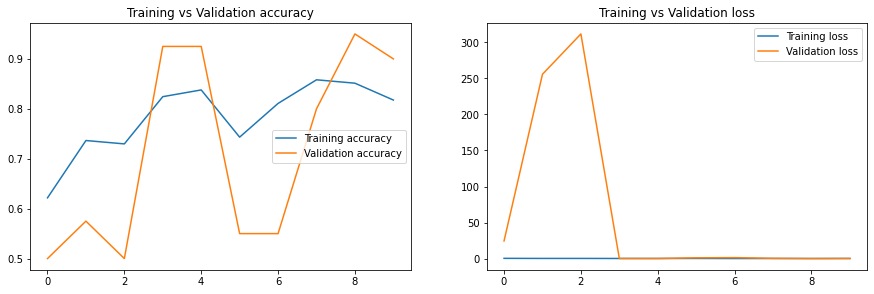

In [36]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs Validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs Validation loss")

plt.show()

In [63]:
evaluation =vgg16_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = vgg16_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

40/40 [==============================] - 4s 90ms/step - loss: 0.4005 - accuracy: 0.8250 - precision: 1.0000 - recall: 0.6500
Test Accuracy: 82.50%
19/19 [==============================] - 13s 691ms/step - loss: 0.6531 - accuracy: 0.7703 - precision: 1.0000 - recall: 0.5405
Train Accuracy: 77.03%


In [42]:
real = test.classes
real

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [66]:
predictions = model.predict(test) > 0.5
# predictions = [0 if x == False else 1 for x in predictions]
predictions
# predictions = [0 if x > 0.5 else 1 for x in predictions]

# pred = model.predict(test)
# pred
# print(confusion_matrix(test.classes, pred > 0.5))

40/40 [==============================] - 5s 126ms/step


array([[[[False, False, False, ...,  True, False, False],
         [False, False, False, ...,  True, False, False],
         [False, False, False, ...,  True, False, False],
         [False, False, False, ...,  True, False, False],
         [False, False, False, ...,  True, False, False]],

        [[False, False, False, ...,  True, False, False],
         [False, False, False, ...,  True, False, False],
         [False, False, False, ...,  True, False, False],
         [False, False, False, ...,  True, False, False],
         [False, False, False, ...,  True, False, False]],

        [[False, False, False, ...,  True, False, False],
         [False, False, False, ...,  True, False, False],
         [False, False, False, ...,  True, False, False],
         [False, False, False, ...,  True, False, False],
         [False, False, False, ...,  True, False, False]],

        [[False, False, False, ...,  True, False, False],
         [False, False, False, ...,  True, False, False],
        

In [48]:
def plot_confusion_matrix(mat, target_names, title='Confusion Matrix', cmap=None):
    accuracy = np.trace(mat) / float(np.sum(mat))
    misclass = 1 - accuracy
    
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.grid('off')
    plt.show()

In [49]:

from sklearn.metrics import confusion_matrix

mat = confusion_matrix(real, predictions)

plot_confusion_matrix(mat, test_set.class_names)

ValueError: Classification metrics can't handle a mix of binary and unknown targets